In [1]:
import sys
sys.path.insert(0, '..')

%matplotlib inline
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
train_data = pd.read_csv('../oreilly/sampled_training.csv')
test_data = pd.read_csv('../oreilly/sampled_test.csv')

In [ ]:
print(train_data.shape)
print(test_data.shape)

In [ ]:
train_data.iloc[0:4, :]

In [ ]:
test_data.iloc[0:4, :]

In [3]:
#Delete "10000" for final version
all_features = pd.concat((train_data.iloc[:10000, 2:], test_data.iloc[:10000, 1:]))
#print(all_features.shape)
#all_features.iloc[[0, 1, 2, 3, -3, -2, -1], [0, 1, 2, 3, -3, -2, -1]]

In [4]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# After standardizing the data all means vanish, hence we can set missing
# values to 0
all_features = all_features.fillna(0)

In [5]:
# Dummy_na=True refers to a missing value being a legal eigenvalue, and
# creates an indicative feature for it
all_features = pd.get_dummies(all_features, dummy_na=True, sparse=True)
#print(all_features.shape)
#all_features.iloc[[0, 1, 2, 3, -3, -2, -1], [0, 1, 2, 3, -3, -2, -1]]

In [6]:
#n_train = train_data.shape[0]
n_train = 10000 #Use line above for final version
train_features = nd.array(all_features[:n_train].values)
test_features = nd.array(all_features[n_train:].values)
train_labels = nd.array(train_data.click.values[:n_train]).reshape((-1, 1))
test_labels = None

In [7]:
batch_size = 256
test_iter = gdata.DataLoader(test_features, batch_size, shuffle = True)

def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    return net
net = get_net()

loss = gloss.SoftmaxCrossEntropyLoss(axis = 0, sparse_label = False)
#loss = gloss.L2Loss()

trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})
learning_rate = 0.01
weight_decay = 0
num_epochs = 100

def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {
        'learning_rate': learning_rate, 'wd': weight_decay})
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [8]:
def rmse(net, features, labels):
    # To further stabilize the value when the logarithm is taken, set the
    # value less than 1 as 1
    #clipped_preds = nd.clip(net(features), 1, float('inf'))
    rmse = loss(net(features), labels).mean()
    #rmse = nd.sqrt(2 * loss(clipped_preds.log(), labels.log()).mean())
    return rmse.asscalar()
#train(net, train_features, train_labels, test_features, test_labels,
#          num_epochs, learning_rate, weight_decay, batch_size)

In [ ]:
#loss = gloss.SoftmaxCrossEntropyLoss(axis = 0, sparse_label = False)
loss = gloss.L2Loss()
#print(rmse(net, train_features, train_labels))
#loss(features,label)
#print(net(train_features))
print(net(train_features))
print(train_labels)
#nd.transpose(net(train_features)).shape
print(nd.softmax(net(train_features)))
print(loss(net(train_features), train_labels))
loss(net(train_features), train_labels).mean()

In [9]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = nd.concat(X_train, X_part, dim=0)
            y_train = nd.concat(y_train, y_part, dim=0)
    return X_train, y_train, X_valid, y_valid

def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None):
    """Plot x and log(y)."""
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)
    plt.show()

def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print('fold %d, train loss: %f, valid loss: %f' % (
            i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

In [10]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 1, 0, 256
#train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
#                          weight_decay, batch_size)
#print('%d-fold validation: avg train loss: %f, avg valid loss: %f'
#      % (k, train_l, valid_l))

In [38]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    # Apply the network to the test set
    preds = net(test_features).asnumpy()
    preds = preds - min(preds)
    preds = preds / max(preds)
    # Reformat it for export to Kaggle
    test_data['click'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['id'], test_data['click']], axis=1)
    submission.to_csv('submission.csv', index=False)

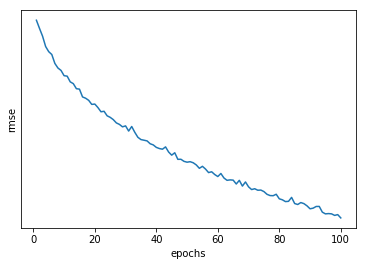

train rmse 13898.188477


In [39]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)